<a href="https://colab.research.google.com/github/siddharth-0704/StockAnalysis/blob/main/stock_ananalysis_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 74.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
import yfinance as yf
import torch
import numpy as np
from tqdm import tqdm
from scipy import special
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def fetch_data(ticker, start_date, end_date):

    data = yf.download(ticker, start=start_date, end=end_date)

    data['Returns'] = data['Adj Close'].pct_change()
    data.dropna(inplace=True)
    return data['Returns'].values

In [ ]:
def train_gbm(data):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    W = torch.tensor(data + 1, device=device).float().view(-1, 1)
    W_init = torch.cat((torch.ones((W.size(0), 1)).to(device), W), dim=1)[:, :-1]

    dT_init = np.ones(W.size(1)).astype(float)
    sigma_init = np.random.randn(W.size(1)) * 0.01 + 1
    mu_param = torch.tensor(np.random.randn(W.size(1)) * 0.01, device=device).requires_grad_(True)

    with torch.no_grad():
        dT_param_log = torch.log(torch.tensor(dT_init)).to(device).requires_grad_(True)
        sigma_param_log = torch.log(torch.tensor(sigma_init)).to(device).requires_grad_(True)

    opt = torch.optim.Adam([dT_param_log, sigma_param_log, mu_param], lr=0.001)
    for iteration in tqdm(range(15000)):
        opt.zero_grad()
        dT_log = torch.cat([torch.zeros(1, device=device), dT_param_log])
        dT = torch.exp(dT_log).view((1, -1))
        sigmas = torch.exp(sigma_param_log).view((-1, 1))
        mus = mu_param.view((-1, 1))
        ln_W = torch.log(W)
        ln_W_init = torch.log(W_init)
        log_prob = -ln_W - torch.log(sigmas) - 0.5 * torch.log(dT) - (
            ln_W - ln_W_init - (mus - 0.5 * sigmas**2) @ dT
        ) ** 2 / (2 * sigmas**2 @ dT)
        row_likelihood = log_prob.sum(dim=1)
        total_likelihood = row_likelihood.mean(dim=0)
        negative_total_likelihood = -total_likelihood
        if iteration % 1000 == 0:
            print(negative_total_likelihood)
        negative_total_likelihood.backward()
        opt.step()

    times = torch.exp(torch.cat([torch.zeros(1, device=device), dT_param_log])).cumsum(dim=0)
    mus = mu_param.detach().cpu().numpy()
    sigmas = torch.exp(sigma_param_log).detach().cpu().numpy()
    horizons = times.detach().cpu().numpy()

    return mus, sigmas, horizons


In [ ]:
def analyze_stock_for_tomorrow(data, mus, sigmas, horizons):
    horizon = horizons[0]
    expected_return = np.exp(mus * horizon) - 1
    lam = sigmas * np.sqrt(horizon)
    row = (mus - 0.5 * sigmas**2) * horizon
    probability_greater_zero = 0.5 - 0.5 * special.erf(-row / (np.sqrt(2) * lam))
    return expected_return, probability_greater_zero


In [ ]:
def ai_agent_for_tomorrow(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)["Adj Close"]
    log_returns = np.log(data / data.shift(1)).dropna().values
    mus, sigmas, horizons = train_gbm(log_returns)
    result = analyze_stock_for_tomorrow(log_returns, mus, sigmas, horizons)


    return data, log_returns, mus, sigmas, horizons, result


In [ ]:
def plot_visualizations(ticker, start_date, end_date):
    data, log_returns, mus, sigmas, horizons, result = ai_agent_for_tomorrow(ticker, start_date, end_date)


    n = len(data)
    mus = mus[:n]
    sigmas = sigmas[:n]
    horizons = horizons[:n]

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data)
    plt.title(f'{ticker} Stock Price History')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(log_returns, kde=True, bins=50)
    plt.title(f'{ticker} Log Returns Distribution')
    plt.xlabel('Log Return')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    return result

[*********************100%***********************]  1 of 1 completed
  0%|          | 51/15000 [00:00<00:56, 266.32it/s]

tensor(0.2490, dtype=torch.float64, grad_fn=<NegBackward0>)


  7%|▋         | 1076/15000 [00:01<00:24, 575.69it/s]

tensor(-2.3438, dtype=torch.float64, grad_fn=<NegBackward0>)


 14%|█▍        | 2098/15000 [00:03<00:22, 573.24it/s]

tensor(-4.7179, dtype=torch.float64, grad_fn=<NegBackward0>)


 20%|██        | 3053/15000 [00:06<00:31, 381.34it/s]

tensor(-6.1535, dtype=torch.float64, grad_fn=<NegBackward0>)


 27%|██▋       | 4067/15000 [00:08<00:17, 613.68it/s]

tensor(-6.4955, dtype=torch.float64, grad_fn=<NegBackward0>)


 34%|███▍      | 5102/15000 [00:10<00:16, 590.32it/s]

tensor(-6.7812, dtype=torch.float64, grad_fn=<NegBackward0>)


 41%|████      | 6099/15000 [00:11<00:14, 595.47it/s]

tensor(-6.9272, dtype=torch.float64, grad_fn=<NegBackward0>)


 47%|████▋     | 7075/15000 [00:13<00:13, 566.19it/s]

tensor(-6.9561, dtype=torch.float64, grad_fn=<NegBackward0>)


 54%|█████▍    | 8088/15000 [00:15<00:11, 613.37it/s]

tensor(-6.9575, dtype=torch.float64, grad_fn=<NegBackward0>)


 60%|██████    | 9046/15000 [00:18<00:21, 275.68it/s]

tensor(-6.9574, dtype=torch.float64, grad_fn=<NegBackward0>)


 67%|██████▋   | 10063/15000 [00:20<00:12, 379.86it/s]

tensor(-6.9575, dtype=torch.float64, grad_fn=<NegBackward0>)


 74%|███████▍  | 11088/15000 [00:23<00:07, 555.55it/s]

tensor(-6.9575, dtype=torch.float64, grad_fn=<NegBackward0>)


 81%|████████  | 12103/15000 [00:25<00:05, 489.08it/s]

tensor(-6.9575, dtype=torch.float64, grad_fn=<NegBackward0>)


 87%|████████▋ | 13097/15000 [00:27<00:03, 612.11it/s]

tensor(-6.9575, dtype=torch.float64, grad_fn=<NegBackward0>)


 94%|█████████▍| 14092/15000 [00:28<00:01, 616.20it/s]

tensor(-6.9575, dtype=torch.float64, grad_fn=<NegBackward0>)


100%|██████████| 15000/15000 [00:30<00:00, 490.83it/s]


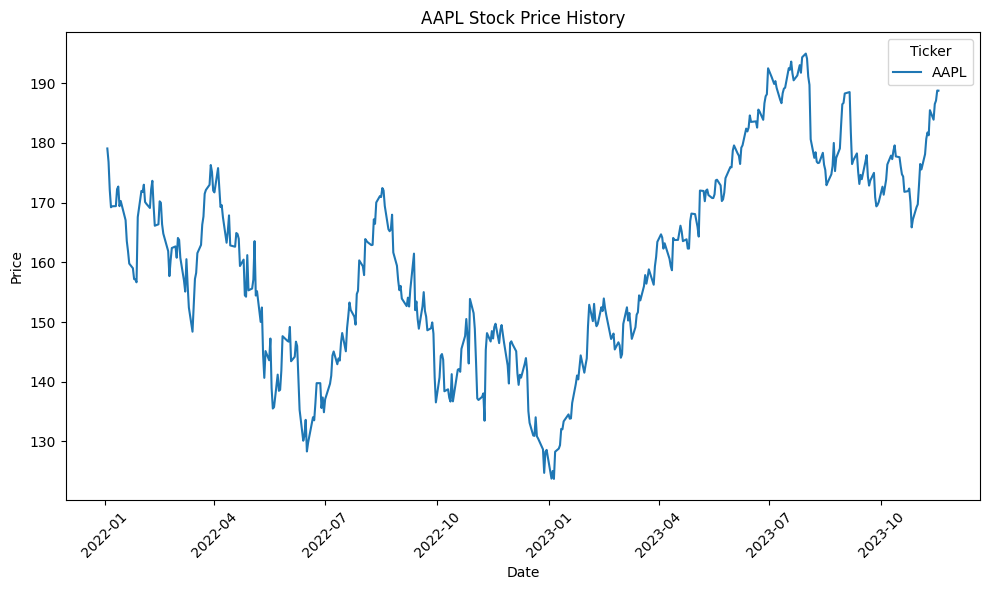

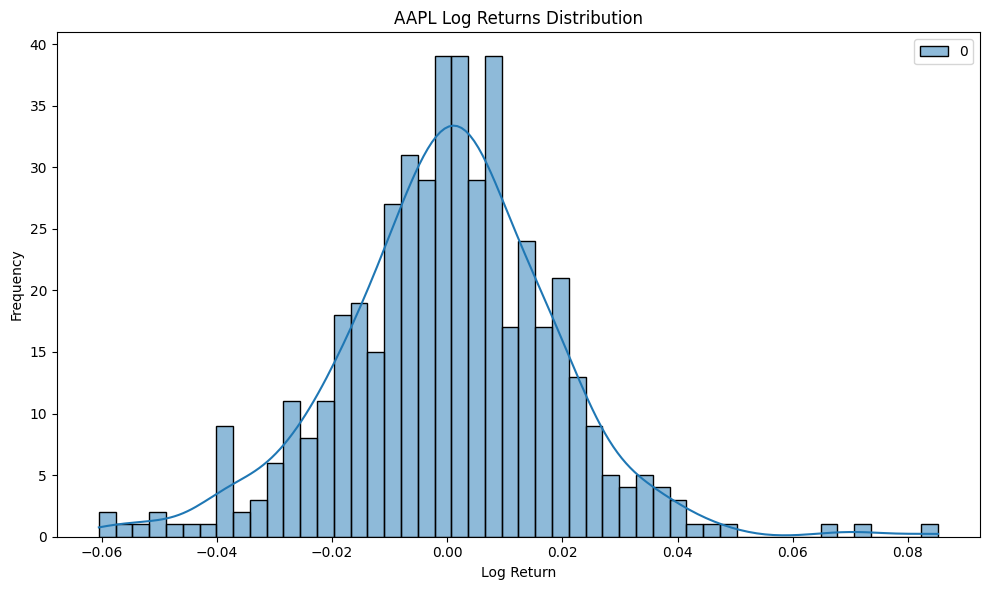

[*********************100%***********************]  1 of 1 completed
  0%|          | 39/15000 [00:00<00:39, 381.74it/s]

tensor(0.2522, dtype=torch.float64, grad_fn=<NegBackward0>)


  7%|▋         | 1104/15000 [00:02<00:27, 498.47it/s]

tensor(-2.3622, dtype=torch.float64, grad_fn=<NegBackward0>)


 14%|█▍        | 2108/15000 [00:04<00:22, 561.36it/s]

tensor(-4.7465, dtype=torch.float64, grad_fn=<NegBackward0>)


 21%|██        | 3087/15000 [00:06<00:21, 555.05it/s]

tensor(-6.2682, dtype=torch.float64, grad_fn=<NegBackward0>)


 27%|██▋       | 4061/15000 [00:08<00:20, 546.28it/s]

tensor(-6.6255, dtype=torch.float64, grad_fn=<NegBackward0>)


 34%|███▎      | 5035/15000 [00:10<00:17, 567.75it/s]

tensor(-6.9221, dtype=torch.float64, grad_fn=<NegBackward0>)


 40%|████      | 6064/15000 [00:13<00:21, 408.74it/s]

tensor(-7.0836, dtype=torch.float64, grad_fn=<NegBackward0>)


 47%|████▋     | 7051/15000 [00:16<00:22, 358.54it/s]

tensor(-7.1189, dtype=torch.float64, grad_fn=<NegBackward0>)


 53%|█████▎    | 8001/15000 [00:17<00:12, 569.13it/s]

tensor(-7.1209, dtype=torch.float64, grad_fn=<NegBackward0>)


 60%|██████    | 9054/15000 [00:20<00:10, 556.97it/s]

tensor(-7.1210, dtype=torch.float64, grad_fn=<NegBackward0>)


 67%|██████▋   | 10099/15000 [00:22<00:09, 539.62it/s]

tensor(-7.1210, dtype=torch.float64, grad_fn=<NegBackward0>)


 74%|███████▎  | 11030/15000 [00:25<00:18, 214.85it/s]

tensor(-7.1210, dtype=torch.float64, grad_fn=<NegBackward0>)


 81%|████████  | 12090/15000 [00:28<00:07, 411.15it/s]

tensor(-7.1210, dtype=torch.float64, grad_fn=<NegBackward0>)


 87%|████████▋ | 13008/15000 [00:32<00:21, 90.72it/s] 

tensor(-7.1210, dtype=torch.float64, grad_fn=<NegBackward0>)


 94%|█████████▍| 14080/15000 [00:37<00:02, 329.64it/s]

tensor(-7.1210, dtype=torch.float64, grad_fn=<NegBackward0>)


100%|██████████| 15000/15000 [00:39<00:00, 384.44it/s]


AI Agent Analysis:
(Ticker                           AAPL
Date                                 
2022-01-03 00:00:00+00:00  179.076584
2022-01-04 00:00:00+00:00  176.803833
2022-01-05 00:00:00+00:00  172.100861
2022-01-06 00:00:00+00:00  169.227936
2022-01-07 00:00:00+00:00  169.395187
...                               ...
2024-11-13 00:00:00+00:00  225.119995
2024-11-14 00:00:00+00:00  228.220001
2024-11-15 00:00:00+00:00  225.000000
2024-11-18 00:00:00+00:00  228.020004
2024-11-19 00:00:00+00:00  228.279999

[725 rows x 1 columns], array([[-1.27727273e-02],
       [-2.69601261e-02],
       [-1.68341651e-02],
       [ 9.87833311e-04],
       [ 1.16193941e-04],
       [ 1.66445331e-02],
       [ 2.56678816e-03],
       [-1.92113213e-02],
       [ 5.09768990e-03],
       [-1.90750558e-02],
       [-2.12488296e-02],
       [-1.04011814e-02],
       [-1.28471173e-02],
       [-4.87638677e-03],
       [-1.14496667e-02],
       [-5.63512777e-04],
       [-2.94749384e-03],
       [ 6.7450803

In [ ]:
plot_visualizations("AAPL", "2022-01-01", "2023-11-20")
result = ai_agent_for_tomorrow("AAPL", "2022-01-01", "2024-11-20")
print("\nAI Agent Analysis:")
print(result)


**TENSORFLOW MODEL USING LSTM**

In [ ]:
!pip uninstall keras keras-nightly keras-preprocessing keras-applications -y
!pip install tensorflow
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

Found existing installation: keras 3.5.0
Uninstalling keras-3.5.0:
  Successfully uninstalled keras-3.5.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.4 MB/s eta 0:00:00


In [ ]:
def prepare_data(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

In [ ]:
def train_lstm_model(data, look_back=60, epochs=10, batch_size=32):
    # Normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))

    # Prepare data for LSTM
    X, y = prepare_data(scaled_data, look_back)

    # Split into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape for LSTM input
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build LSTM model
    model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1)
    ])


    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test))

    return model, scaler

In [ ]:
def predict_next_day(model, scaler, data, look_back=60):
    last_days = data[-look_back:].reshape(-1, 1)
    last_days_scaled = scaler.transform(last_days)
    input_data = last_days_scaled.reshape((1, look_back, 1))

    prediction_scaled = model.predict(input_data)
    prediction = scaler.inverse_transform(prediction_scaled)

    return prediction[0, 0]

In [ ]:
def stock_prediction_lstm(ticker, start_date, end_date, look_back=60):
    # Download stock data
    data = yf.download(ticker, start=start_date, end=end_date)["Adj Close"].values

    # Train LSTM model
    model, scaler = train_lstm_model(data, look_back=look_back, epochs=10, batch_size=32)

    # Predict next day's price
    next_day_price = predict_next_day(model, scaler, data, look_back=look_back)

    return next_day_price

In [ ]:
# Call the function
ticker = "AAPL"
start_date = "2022-01-01"
end_date = "2024-11-21"
predicted_price = stock_prediction_lstm(ticker, start_date, end_date)
print(f"Predicted stock price for {ticker} on the next trading day: {predicted_price:.2f}")

[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0875 - val_loss: 0.0710
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0087 - val_loss: 0.0252
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0044 - val_loss: 0.0129
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0037 - val_loss: 0.0092
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0033 - val_loss: 0.0055
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0032 - val_loss: 0.0068
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0027 - val_loss: 0.0040
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0025 - val_loss: 0.0041
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
Predicted stock price for AAPL on the next trading day: 222.28
